In [1]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd

In [2]:
import phate, magic, meld
import pandas as pd
import dbio, os
import scprep
import graphtools as gt

font = {'size'   : 18}
mpl.rc('font', **font)

In [3]:
markers = np.array(['Event_length', 'CD45', 'CD196', 'T-bet', 'CD127',
       'CD69', 'CD4', 'CD8a', 'CD7', 'CD200R', 'CD25', 'CD38',
       'Beads-CD278', 'TNFa', 'Baeds-Tim-3', 'CD185', 'CD36', 'CD95',
       'CD137', 'CD197', 'CD28', 'CD152', 'FoxP3', 'CXCR3', 'CD45RO',
       'Beads-IFNg', 'LAG-3', 'GzmB', 'Ki-67', 'Eomes', 'CD3', 'CD226',
       'CD274', 'TIGIT', 'TCF7', 'Beads-PD-1', 'IL-10', 'DNA1', 'DNA2',
       'Cispt', 'CD11b'], dtype='<U12')

In [4]:
base_path = '/data/lab/DataSets/SBRT/20170830-RD3475-Run_2/'

def load_fcs(path):
    meta, x = dbio.fcsextract(path)
    
    gene_names = {}
    for i in range(1,x.shape[1]+1):
        key = '$P{}S'.format(i)
        if key in meta:
            if '_' in meta[key]:
                gene_names[i] = meta[key].split('_')[1]
            else:
                gene_names[i] = meta[key]
        else:
            key = '$P{}N'.format(i)
            gene_names[i] = meta[key]
    
    gene_names = np.array([*gene_names.values()])
    
    markers = np.array(['Event_length', 'CD45', 'CD196', 'T-bet', 'CD127',
       'CD69', 'CD4', 'CD8a', 'CD7', 'CD200R', 'CD25', 'CD38',
       'Beads-CD278', 'TNFa', 'Baeds-Tim-3', 'CD185', 'CD36', 'CD95',
       'CD137', 'CD197', 'CD28', 'CD152', 'FoxP3', 'CXCR3', 'CD45RO',
       'Beads-IFNg', 'LAG-3', 'GzmB', 'Ki-67', 'Eomes', 'CD3', 'CD226',
       'CD274', 'TIGIT', 'TCF7', 'Beads-PD-1', 'IL-10', 'DNA1', 'DNA2',
       'Cispt', 'CD11b'], dtype='<U12')
    
    try:
        assert np.all([m in gene_names for m in markers])
    
        data = pd.DataFrame(x, columns = gene_names)
        marker_data = scprep.utils.select_cols(data, markers)
        return marker_data
    except AssertionError:
        import warnings
        warnings.warn('Marker list not found in column names. Returning raw FCS data!')
        return  pd.DataFrame(x, columns = gene_names)


### Importing data

In [12]:
sample_info = pd.read_csv('../files/sample_info.csv', index_col=0)

#### Select Pre and Post-1 from Run 1

In [13]:
sample_mask = np.isin(sample_info['time_RES'], [-2, -1, 1]) & (sample_info['run'] == 2)
print('# samples: {}'.format(np.sum(sample_mask)))

# samples: 8


#### Load data

In [14]:
all_data = []
for fn in sample_info.loc[sample_mask]['filename']:
    all_data.append(load_fcs(os.path.join(base_path, fn)))

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Marker list not found in column names. Returning raw FCS data!
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Marker list not found in column names. Returning raw FCS data!
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Marker list not found in column names. Returning raw FCS data!
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Marker list not found in column names. Returning raw FCS data!
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Marker list not found in column names. Returning raw FCS data!
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Marker list not found in column names. Returning raw FCS data!
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Marker list not found in column names. Returning raw FCS data!
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:

In [15]:
all_data[0].columns

Index(['Time', 'Event_length', 'CD45', '102Pd', '104Pd', '105Pd', '106Pd',
       '108Pd', '110Pd', 'Beads', 'CCR6', 'Beads', 'T-bet', 'CD127', 'CD69',
       'CD4', 'CD8a', 'CD7', 'CD200R', 'CD25', 'CD38', 'Beads-ICOS', 'TNF-a',
       'Baeds-Tim-3', 'CXCR5', 'CD36', 'CD95', 'CD137', 'CCR7', 'CD28',
       'CTLA-4', 'FoxP3', 'CXCR3', 'CD45RO', 'Beads-IFN-g', 'LAG-3', 'GzmB',
       'Ki-67', 'Eomes', 'CD3', 'DNAM-1', 'PD-L1', 'TIGIT', 'TCF7',
       'Beads-PD-1', 'IL-10', 'DNA1', 'DNA2', 'Cispt', 'CD11b', 'Center',
       'Offset', 'Width', 'Residual', 'separation', 'dist'],
      dtype='object')

In [16]:
data, batches = scprep.utils.combine_batches(all_data, sample_info.loc[sample_mask].index, append_to_cell_names=True)

metadata = sample_info.loc[batches]

metadata.index.name = 'sample'
metadata = metadata.reset_index()
metadata.index = data.index

### QC & Processing

In [17]:
mkdir -p ../figs/run2.pre_and_post

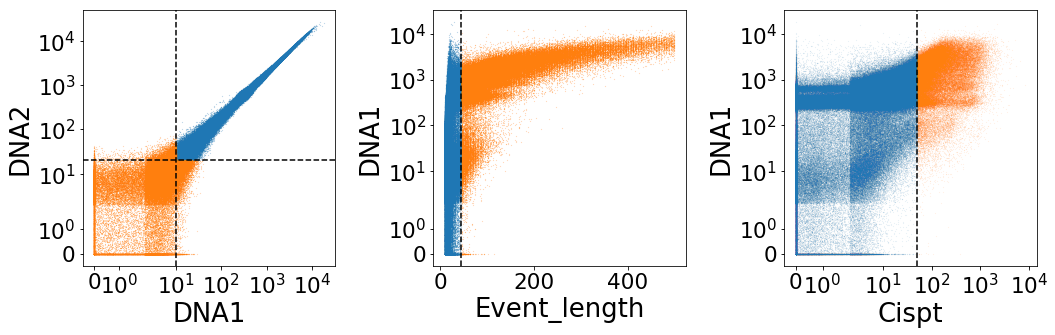

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# DNA1 vs DNA2
ax = axes[0]
ax.set_xscale('symlog')
ax.set_yscale('symlog')

dna1_thresh = 10
dna2_thresh = 20

m1 = data['DNA1'] < dna1_thresh
m2 = data['DNA2'] < dna2_thresh
dna_m = m1 | m2
ax.axvline(dna1_thresh, linestyle='--', c='k')
ax.axhline(dna2_thresh, linestyle='--', c='k')
scprep.plot.scatter(data['DNA1'].loc[~dna_m], data['DNA2'].loc[~dna_m], 
                    ax=ax, s=0.01)

scprep.plot.scatter(data['DNA1'].loc[dna_m], data['DNA2'].loc[dna_m], ax=ax,
                    xlabel='DNA1', ylabel='DNA2', s=0.01)

# event_length vs DNA1
ax = axes[1]
x = 'Event_length'
y = 'DNA1'
ax.set_yscale('symlog')

# Threshold
event_thresh = 45
event_m = data[x] > event_thresh

# Plot
scprep.plot.scatter(data[x][~event_m], data[y][~event_m], ax=ax,
                   xlabel=x, ylabel=y, s=0.01)
scprep.plot.scatter(data[x].loc[event_m], data[y].loc[event_m], ax=ax, s=0.01)

ax.axvline(event_thresh, linestyle='--', c='k')

## Cispt vs DNA1
ax = axes[2]
x = 'Cispt'
y = 'DNA1'

ax.set_xscale('symlog')
ax.set_yscale('symlog')

# Threshold
cispt_thresh = 50
cispt_m = data[x] > cispt_thresh

# Plot
scprep.plot.scatter(data[x].loc[~cispt_m], data[y].loc[~cispt_m], ax=ax,
                  s=0.001)
scprep.plot.scatter(data[x].loc[cispt_m], data[y].loc[cispt_m], ax=ax,
                    xlabel=x, ylabel=y, s=0.001)
ax.axvline(cispt_thresh, linestyle='--', c='k')


fig.tight_layout()
#fig.savefig('../figs/pre_at_post/all.filtering.png', dpi=300)

#### KDE plot

/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:493: FutureWarning: `scprep.utils.subsample` is deprecated. Use `scprep.select.subsample` instead.
  FutureWarning)


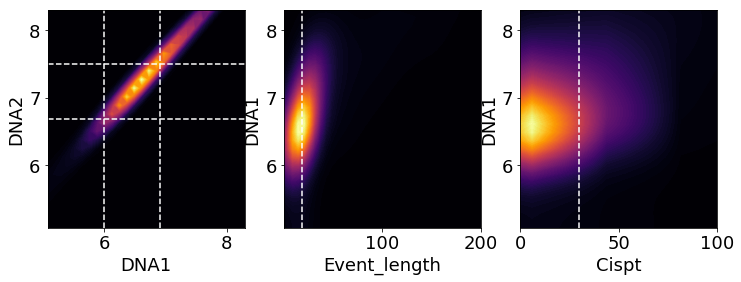

In [19]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

data_sub = scprep.utils.subsample(data.values, n=10000)

data_sub = pd.DataFrame(data_sub, columns = data.columns)

## DNA1 vs DNA2
ax = axes[0]
ax = sns.kdeplot(np.arcsinh(data_sub['DNA1']), np.arcsinh(data_sub['DNA2']), shade=True, levels=100, cmap='inferno', ax=ax)
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
ax.set_xlim((np.arcsinh(8e1), np.arcsinh(2e3)))
ax.set_ylim((np.arcsinh(8e1), np.arcsinh(2e3)))

ax.axhline(np.arcsinh(400), linestyle='--', color='white')
ax.axhline(np.arcsinh(900), linestyle='--', color='white')
ax.axvline(np.arcsinh(200), linestyle='--', color='white')
ax.axvline(np.arcsinh(500), linestyle='--', color='white')

## Event length vs DNA1
ax = axes[1]

ax = sns.kdeplot(data_sub['Event_length'], np.arcsinh(data_sub['DNA1']), shade=True, levels=100, cmap='inferno', ax=ax)
#ax.set_yscale('symlog')
ax.set_xlim((1, 200))
ax.set_ylim((np.arcsinh(8e1), np.arcsinh(2e3)))


ax.axvline(19, linestyle='--', color='white')

## Cispt vs DNA1
ax = axes[2]

ax = sns.kdeplot(data_sub['Cispt'], np.arcsinh(data_sub['DNA1']), shade=True, levels=100, cmap='inferno', ax=ax)
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
ax.set_xlim((0, 100))
ax.set_ylim((np.arcsinh(8e1), np.arcsinh(2e3)))

ax.axvline(30, linestyle='--', color='white')

#### Applying filters

In [20]:
# DNA1 vs DNA2
data_filt = scprep.filter.filter_values(data,  values=data['DNA1'], cutoff=200, keep_cells='above')
data_filt = scprep.filter.filter_values(data_filt,  values=data_filt['DNA1'], cutoff=500, keep_cells='below')
data_filt = scprep.filter.filter_values(data_filt,  values=data_filt['DNA2'], cutoff=400, keep_cells='above')
data_filt = scprep.filter.filter_values(data_filt,  values=data_filt['DNA2'], cutoff=900, keep_cells='below')

# Event length
data_filt = scprep.filter.filter_values(data_filt,  values=data_filt['Event_length'], cutoff=19, keep_cells='below')

# Cisplatin
data_filt = scprep.filter.filter_values(data_filt,  values=data_filt['Cispt'], cutoff=30, keep_cells='below')

# Metadata
metadata_filt = metadata.loc[data_filt.index]

In [21]:
metadata.head()

,sample,filename,sample_id,date,stimulated,pre_post_sbrt,time_RES,response,response_RES,days_to_progression,run,progression_RES
0_L-30_Poor_Pre,L-30_Poor_Pre,L-30_60116_PROGRESSION_Simulated.E.5.fcs,L-30,6/1/16,Y,Pre,-1,Poor,-1,80,2,-0.644205
1_L-30_Poor_Pre,L-30_Poor_Pre,L-30_60116_PROGRESSION_Simulated.E.5.fcs,L-30,6/1/16,Y,Pre,-1,Poor,-1,80,2,-0.644205
2_L-30_Poor_Pre,L-30_Poor_Pre,L-30_60116_PROGRESSION_Simulated.E.5.fcs,L-30,6/1/16,Y,Pre,-1,Poor,-1,80,2,-0.644205
3_L-30_Poor_Pre,L-30_Poor_Pre,L-30_60116_PROGRESSION_Simulated.E.5.fcs,L-30,6/1/16,Y,Pre,-1,Poor,-1,80,2,-0.644205
4_L-30_Poor_Pre,L-30_Poor_Pre,L-30_60116_PROGRESSION_Simulated.E.5.fcs,L-30,6/1/16,Y,Pre,-1,Poor,-1,80,2,-0.644205


In [22]:
np.unique(metadata_filt['sample'], return_counts=True)

(array(['L-30_Poor_Post-1', 'L-30_Poor_Pre', 'L-34_Poor_Post-1',
        'L-34_Poor_Pre', 'L-35_Excellent_Post-1', 'L-35_Excellent_Pre',
        'L-45_Poor_Post-1', 'L-45_Poor_Very Pre'], dtype=object),
 array([   265,    117,    583,  57190, 119247,  45603,  43600,    383]))

In [23]:
groups, counts = np.unique(metadata_filt['sample'], return_counts=True)

batch_cmap = {g:sns.husl_palette(len(groups))[i] for i, g in enumerate(groups)}

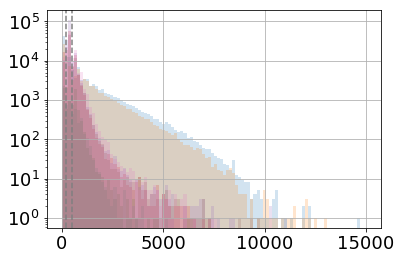

In [24]:
fig, ax = plt.subplots(1, figsize=(6,4))

data['DNA1'].groupby(by=metadata['sample']).hist(range=(0,15000), bins=100, log=True, alpha=0.2, ax=ax)

ax.axvline(200, linestyle='--', color='grey')
ax.axvline(500, linestyle='--', color='grey')

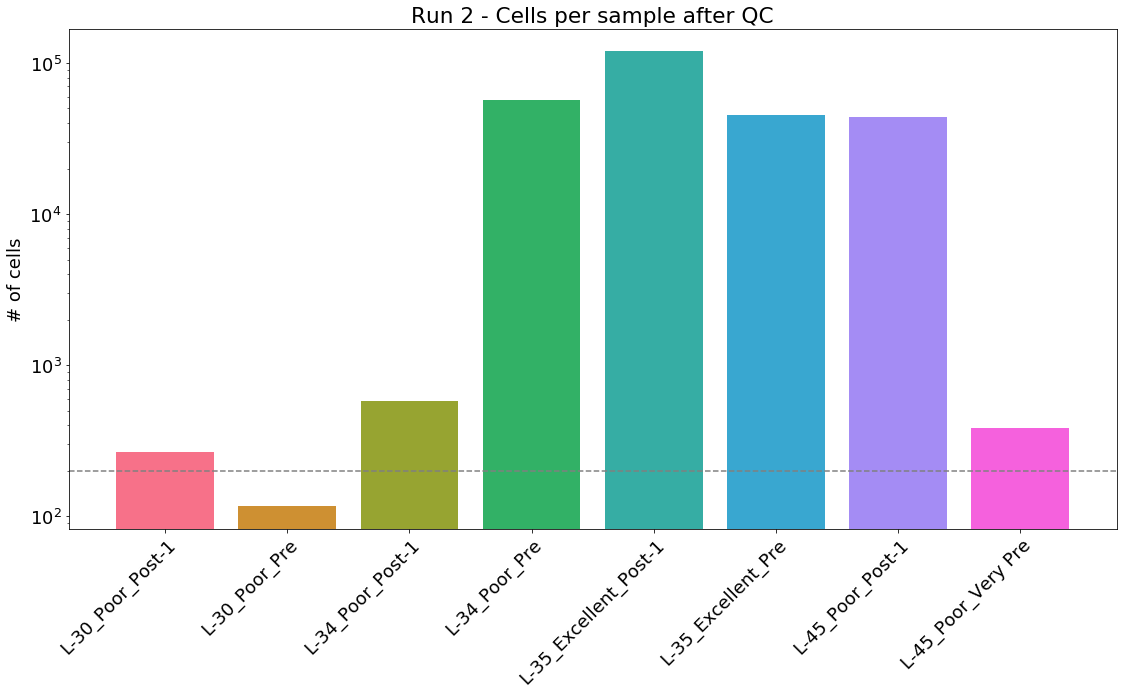

In [25]:
fig, ax = plt.subplots(1, figsize=(16,10))
i = -1
for group, count in zip(groups, counts):
    i += 1
    ax.bar(i, count, color=batch_cmap[group])
ax.set_xticks(np.arange(len(groups)))   
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.set_ylabel('# of cells')
ax.set_yscale('log')

ax.axhline(200, linestyle='--', color='grey')

dbio.shift_ticklabels(fig, ax, dx=0.2)

ax.set_title('Run 2 - Cells per sample after QC')

fig.tight_layout()
#fig.savefig('../figs/pre_at_post/cells_per_sample.png', dpi=300)

In [26]:
# Number of cells in each sample
print(*zip(groups, counts), sep='\n')

('L-30_Poor_Post-1', 265)
('L-30_Poor_Pre', 117)
('L-34_Poor_Post-1', 583)
('L-34_Poor_Pre', 57190)
('L-35_Excellent_Post-1', 119247)
('L-35_Excellent_Pre', 45603)
('L-45_Poor_Post-1', 43600)
('L-45_Poor_Very Pre', 383)


#### Keeping only relevant markers

In [27]:
markers = np.array(['CD45', 'CCR6', 'T-bet', 'CD127', 'CD69',
       'CD4', 'CD8a', 'CD7', 'CD200R', 'CD25', 'CD38', 'Beads-ICOS', 'TNF-a',
       'Baeds-Tim-3', 'CXCR5', 'CD36', 'CD95', 'CD137', 'CCR7', 'CD28',
       'CTLA-4', 'FoxP3', 'CXCR3', 'CD45RO', 'Beads-IFN-g', 'LAG-3', 'GzmB',
       'Ki-67', 'Eomes', 'CD3', 'DNAM-1', 'PD-L1', 'TIGIT', 'TCF7',
       'Beads-PD-1', 'IL-10', 'CD11b'], dtype='<U12')

In [28]:
marker_data = scprep.utils.select_cols(data_filt, markers)
print(marker_data.shape)
marker_data.head()

(266988, 37)


/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:463: FutureWarning: `scprep.utils.select_cols` is deprecated. Use `scprep.select.select_cols` instead.
  FutureWarning)


,CD45,CCR6,T-bet,CD127,CD69,CD4,CD8a,CD7,CD200R,CD25,...,Ki-67,Eomes,CD3,DNAM-1,PD-L1,TIGIT,TCF7,Beads-PD-1,IL-10,CD11b
6602_L-30_Poor_Pre,0.000000,0.176453,0.000000,0.0,0.000000,0.000000,0.00000,2.954083,0.000000,0.000000,...,2.038950,2.755673,1.276738,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9480_L-30_Poor_Pre,24.968245,0.000000,0.395237,0.0,0.240197,0.617943,0.00000,3.132529,0.000000,0.000000,...,5.768288,0.000000,1.780020,0.0,0.000000,0.000000,1.606129,0.0,2.100845,0.477181
13052_L-30_Poor_Pre,6.429961,0.000000,3.118143,0.0,1.430539,0.000000,0.00000,1.765898,0.000000,0.000000,...,0.748122,0.000000,1.005794,0.0,0.000000,0.000000,5.321271,0.0,0.472769,1.968622
14238_L-30_Poor_Pre,9.299975,0.000000,4.284260,0.0,0.000000,0.000000,1.19784,0.000000,0.000000,0.070908,...,41.305012,1.499167,4.511606,0.0,0.000000,0.115688,7.450553,0.0,4.780163,0.000000
19123_L-30_Poor_Pre,30.552235,0.420232,0.000000,0.0,1.851043,21.155306,0.00000,8.527368,0.742646,37.015427,...,0.992245,0.344643,20.059771,0.0,0.136624,5.502624,0.825333,0.0,5.381352,0.000000



####  Checking CD 185 expression

In [22]:
metadata = metadata.loc[marker_data.index]

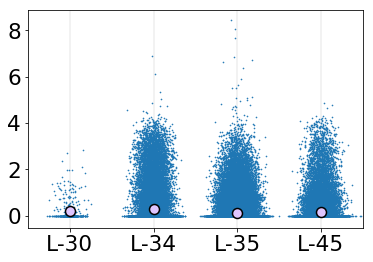

In [23]:
scprep.plot.jitter(metadata['sample_id'], np.arcsinh(marker_data['CXCR5']))


In [24]:
metadata['sample'].unique()

array(['L-30_Poor_Pre', 'L-30_Poor_Post-1', 'L-34_Poor_Pre',
       'L-34_Poor_Post-1', 'L-35_Excellent_Pre', 'L-35_Excellent_Post-1',
       'L-45_Poor_Very Pre', 'L-45_Poor_Post-1'], dtype=object)

In [25]:
np.arcsinh(marker_data['CXCR5']).groupby(metadata['sample']).mean()

sample
L-30_Poor_Post-1         0.228779
L-30_Poor_Pre            0.208962
L-34_Poor_Post-1         0.173634
L-34_Poor_Pre            0.304369
L-35_Excellent_Post-1    0.115253
L-35_Excellent_Pre       0.130933
L-45_Poor_Post-1         0.174230
L-45_Poor_Very Pre       0.230743
Name: CXCR5, dtype: float64

#### Subsample data

In [29]:
data_sub = []
metadata_sub = []
n_subsample = 500
np.random.seed(42)
for b in np.unique(metadata_filt['sample']):
    curr_data = scprep.utils.select_rows(marker_data, np.isin(metadata_filt['sample'], b))
    curr_metadata = scprep.utils.select_rows(metadata_filt, np.isin(metadata_filt['sample'], b))
    if 'Excellent' in b:
        idx = np.random.choice(curr_data.index, (n_subsample * 2) + 132, replace=False)
        curr_subsamp = curr_data.loc[idx]
        curr_metadata_sub = curr_metadata.loc[idx]
    
    elif curr_data.shape[0] <= n_subsample:
        curr_subsamp = curr_data
        curr_metadata_sub = curr_metadata
        print(b, curr_data.shape)
    else:
        
        idx = np.random.choice(curr_data.index, n_subsample, replace=False)
        curr_subsamp = curr_data.loc[idx]
        curr_metadata_sub = curr_metadata.loc[idx]
    data_sub.append(curr_subsamp)
    metadata_sub.append(curr_metadata_sub)

L-30_Poor_Post-1 (265, 37)
L-30_Poor_Pre (117, 37)


/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.

L-45_Poor_Very Pre (383, 37)


/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)


#### Combining subsampled batches and removing duplicates

In [30]:
data_sub = pd.concat(data_sub, axis=0)
metadata_sub = pd.concat(metadata_sub)

In [31]:
np.unique(metadata_sub['response_RES'], return_counts=True)

(array([-1,  1]), array([2265, 2264]))

In [32]:
data_ln = scprep.normalize.library_size_normalize(data_sub)

data_asin = scprep.transform.arcsinh(data_ln)

### PHATE embedding

In [34]:
G = gt.Graph(data_asin, knn=10, use_pygsp=True)

In [31]:
phate_op = phate.PHATE(knn_dist='precomputed', n_jobs=6)
Y = phate_op.fit_transform(G.K)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 4529 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.08 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.85 seconds.
    Calculating KMeans...
    Calculated KMeans in 17.09 seconds.
  Calculated landmark operator in 21.48 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 2.66 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.16 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 23.46 seconds.
Calculated PHATE in 49.86 seconds.


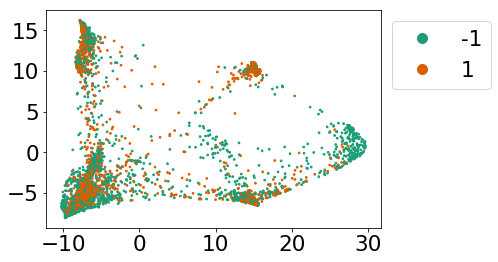

In [32]:
scprep.plot.scatter2d(Y, c=metadata_sub['response_RES'], legend_anchor=(1,1), cmap='Dark2')

In [33]:
phate_op = phate.PHATE(n_components=3, knn_dist='precomputed', n_jobs=12)
Y3D = phate_op.fit_transform(G.K)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 4529 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.85 seconds.
    Calculating KMeans...
    Calculated KMeans in 19.08 seconds.
  Calculated landmark operator in 23.47 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 2.71 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.91 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 28.25 seconds.
Calculated PHATE in 56.43 seconds.


#### MAGIC

In [35]:
import magic

magic_op = magic.MAGIC(k=G.knn, n_pca = G.n_pca, a=G.decay)
data_magic = magic_op.fit_transform(data_asin, graph=G)

data_magic = pd.DataFrame(data_magic, columns = data_asin.columns)

Calculating MAGIC...
  Running MAGIC on 4529 cells and 37 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
    Automatically selected t = 9
  Calculated imputation in 0.41 seconds.
Calculated MAGIC in 0.41 seconds.


In [37]:
#np.savez('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.phate.npz',Y=Y, Y3=Y3D)
G.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.graph.pkl')
data_asin.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.data.pkl')
metadata_sub.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.metadata.pkl')
data_magic.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.data_magic.pkl')

In [40]:
metadata_sub['stimulated'].unique()

array(['Y', 'N'], dtype=object)

In [1]:
run2_data_asin = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.data.pkl')
run2_metadata = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.metadata.pkl')
labels = ['CD45', 'CD196', 'T-bet', 'CD127', 'CD69', 'CD4', 'CD8a', 'CD7',
       'CD200R', 'CD25', 'CD38', 'CD278', 'TNFa', 'Tim-3', 'CD185',
       'CD36', 'CD95', 'CD137', 'CD197', 'CD28', 'CD152', 'FoxP3', 'CXCR3',
       'CD45RO', 'IFNg', 'LAG-3', 'GzmB', 'Ki-67', 'Eomes', 'CD3',
       'CD226', 'CD274', 'TIGIT', 'TCF7', 'PD-1', 'IL-10', 'CD11b']

run2_data_asin.columns = pd.Index(labels)

NameError: name 'pd' is not defined

In [2]:
run1_data_asin = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.data.pkl')
run1_metadata = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.metadata.pkl')

#fix metadata
run1_metadata_updated  = run1_metadata.reset_index()
run1_metadata_updated.columns = pd.Index(['sample', 'filename', 'sample_id', 'date', 'stimulated', 'pre_post_sbrt',
       'time_RES', 'response', 'response_RES', 'days_to_progression', 'run',
       'progression_RES'])
run1_metadata_updated.index = pd.Index(['_'.join([str(i), s]) for i,s in zip(run1_data_asin.index, run1_metadata_updated['sample'])])
run1_metadata = run1_metadata_updated

run1_data_asin.index = pd.Index(['_'.join([str(i), s]) for i,s in zip(run1_data_asin.index, run1_metadata_updated['sample'])])


labels = ['CD45', 'CD196', 'T-bet', 'CD127', 'CD69', 'CD4', 'CD8a', 'CD7',
       'CD200R', 'CD25', 'CD38', 'CD278', 'TNFa', 'CD185', 'CD36',
       'CD95', 'CD137', 'CD197', 'CD28', 'CD152', 'FoxP3', 'CXCR3', 'CD45RO',
       'IFNg', 'LAG-3', 'GzmB', 'Ki-67', 'Eomes', 'CD3', 'CD226',
       'CD274', 'TIGIT', 'TCF7', 'PD-1', 'IL-10', 'CD11b']

run1_data_asin.columns = pd.Index(labels)


NameError: name 'pd' is not defined

In [117]:
data = pd.concat([run1_data_asin, run2_data_asin])[run1_data_asin.columns]
metadata = pd.concat([run1_metadata, run2_metadata])

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [123]:
G = gt.Graph(data, knn=20)

In [124]:
phate_op = phate.PHATE(knn_dist='precomputed', n_jobs=12)
Y = phate_op.fit_transform(G.K)

Calculating PHATE...
  Using precomputed affinity matrix...
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 4.91 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 242.45 seconds.
    Calculating KMeans...
    Calculated KMeans in 30.90 seconds.
  Calculated landmark operator in 281.21 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.90 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.35 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 11.39 seconds.
Calculated PHATE in 298.83 seconds.


In [136]:
data_phate = Y

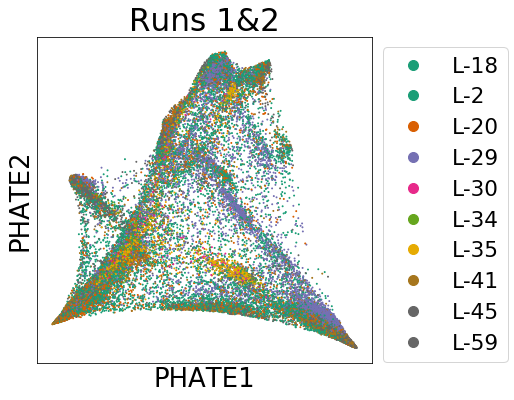

In [132]:
scprep.plot.scatter2d(Y, c=metadata['sample_id'], cmap='Dark2', legend_anchor=(1,1),
                     title='Runs 1&2', figsize=(6,6), ticks=False, label_prefix='PHATE')

In [138]:
response_cmap = {
    'Poor':'#0a516d',
    'Fair':'#738598',
    'Excellent':'#f77754'
}

In [140]:
ax

NameError: name '_e0_' is not defined

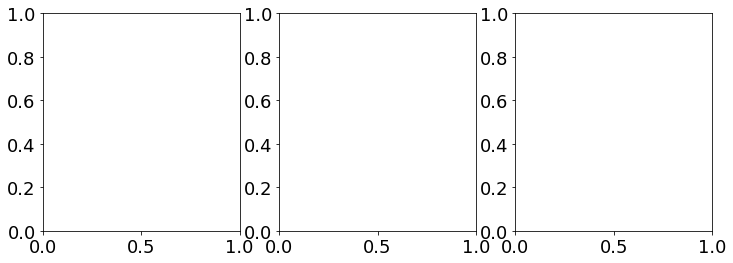

In [148]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

for i, ax in enumerate(axes):
    if i == 0:
        curr_mask = metadata['run'] > 0
        curr_cvec = metadata['sample_id']
        title = 'Runs 1 & 2'
        cmap = 'Dark2'
    elif i == 1:
        curr_mask = metadata['run'] == 1
        curr_cvec = metadata['response']
        title = 'Run 1 only'
        cmap = response_cmap
    elif i == 2:
        curr_mask = metadata['run'] == 2
        curr_cvec = metadata['response']
        title = 'Run 2 only'
        cmap = response_cmap
    
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_cvec[curr_mask], cmap=cmap, 
                     title=title, ticks=False, label_prefix='PHATE', ax=ax)

In [150]:
scprep.plot.scatter2d(data_phate)

NameError: name '_e0_' is not defined

In [151]:
scprep.__file__

'/home/dan/.local/lib/python3.7/site-packages/scprep/__init__.py'

In [137]:
metadata.head()

,sample,filename,sample_id,date,stimulated,pre_post_sbrt,time_RES,response,response_RES,days_to_progression,run,progression_RES
0_L-18_Excellent_Post-1,L-18_Excellent_Post-1,L-18_052016_Post-SBRT.Stimulated.A-B1.fcs,L-18,5/20/16,Y,Post-1,1,Excellent,1,377,1,0.956873
1_L-18_Excellent_Post-1,L-18_Excellent_Post-1,L-18_052016_Post-SBRT.Stimulated.A-B1.fcs,L-18,5/20/16,Y,Post-1,1,Excellent,1,377,1,0.956873
2_L-18_Excellent_Post-1,L-18_Excellent_Post-1,L-18_052016_Post-SBRT.Stimulated.A-B1.fcs,L-18,5/20/16,Y,Post-1,1,Excellent,1,377,1,0.956873
3_L-18_Excellent_Post-1,L-18_Excellent_Post-1,L-18_052016_Post-SBRT.Stimulated.A-B1.fcs,L-18,5/20/16,Y,Post-1,1,Excellent,1,377,1,0.956873
4_L-18_Excellent_Post-1,L-18_Excellent_Post-1,L-18_052016_Post-SBRT.Stimulated.A-B1.fcs,L-18,5/20/16,Y,Post-1,1,Excellent,1,377,1,0.956873
